#**Solar power prediction with KNN**

---



**Importing necessary libraries**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

**Data exploration**

First, the data set is imported and stored:

In [41]:
url = ("https://raw.githubusercontent.com/anacrm00/Solar/main/Pasion_et_al_dataset2.csv")
solar = pd.read_csv(url, header=None)

We add the name of the columns and rearrange them for easier manipulation:

In [42]:
solar.columns = ["Location", "Date", "Time", "Latitude", "Longitude","Altitude","YRMODAHRMI", "Month", "Hour", "Season", "Humidity", 
                 "AmbientTemp","PolyPwr", "Wind.Speed", "Visibility","Pressure", "Cloud.Ceiling"]

solar = solar.reindex(columns=["PolyPwr","Location", "Date", "Time", "Latitude", "Longitude","Altitude","YRMODAHRMI", "Month", "Hour", "Season", "Humidity", 
                 "AmbientTemp", "Wind.Speed", "Visibility","Pressure", "Cloud.Ceiling"])

We can generate the histogram for our target variable PolyPwr, to get an overview of the range of power we can expect

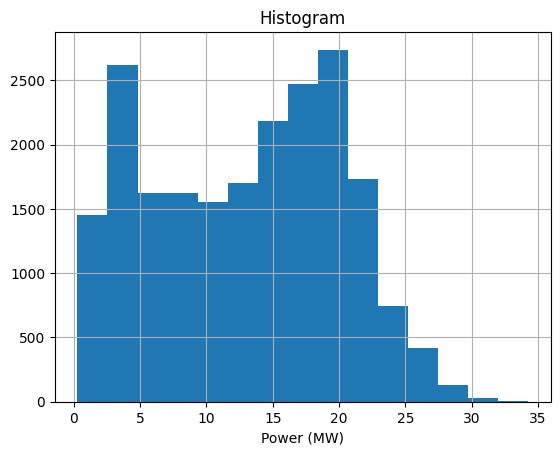

In [43]:
solar["PolyPwr"].hist(bins=15)
plt.xlabel("Power (MW)")
plt.title("Histogram")
plt.show()

We observe that the data does not seem skewed, but there isn't much power output over 30MW. 


We want to study the revelant information and discard any information that will not help us in the prediction. 
This is done thanks to the study of the correlation of the variables, through the correlation matrix. 

<ipython-input-44-7696c1216200>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  solar_corr = solar.corr()
<ipython-input-44-7696c1216200>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(solar.corr(), mask=mask, cmap="YlGnBu", annot=True, fmt=".1f")


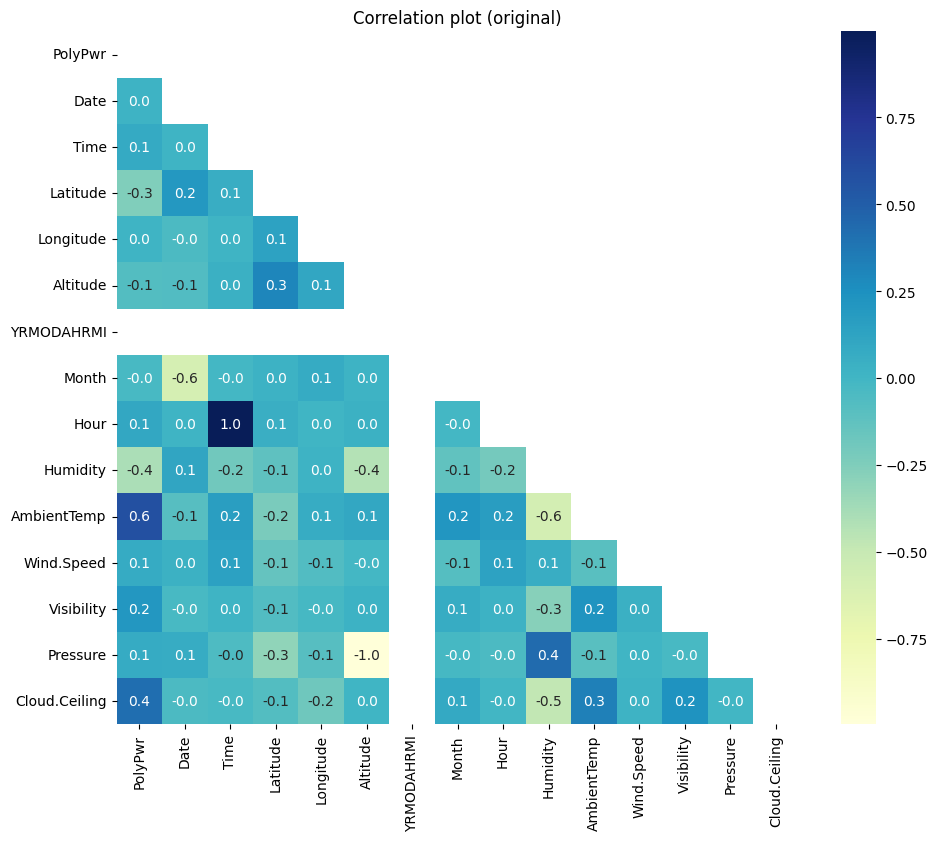

In [44]:
solar_corr = solar.corr()

f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(solar_corr, dtype=bool))

sb.heatmap(solar.corr(), mask=mask, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Correlation plot (original)")
plt.show()

We observe from the correlation plot that the variable "YRMODAHRMI" has no correlation to any other variable and was not explained in the dataset so it is dropped. 

The variables that hold the strongest correlation to our target "PolyPwr" are ambient temperature, humidity and cloud ceiling so these must be kept.

Latitude also holds significant correlation but longitude does not, so it is dropped. 
Date, time, hour and month are also dropped because the have very weak, almost no correlation to the target variable.

<ipython-input-45-93203f642044>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  solar_corr = solar.corr()
<ipython-input-45-93203f642044>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(solar.corr(), mask=mask, cmap="YlGnBu", annot=True, fmt=".1f")


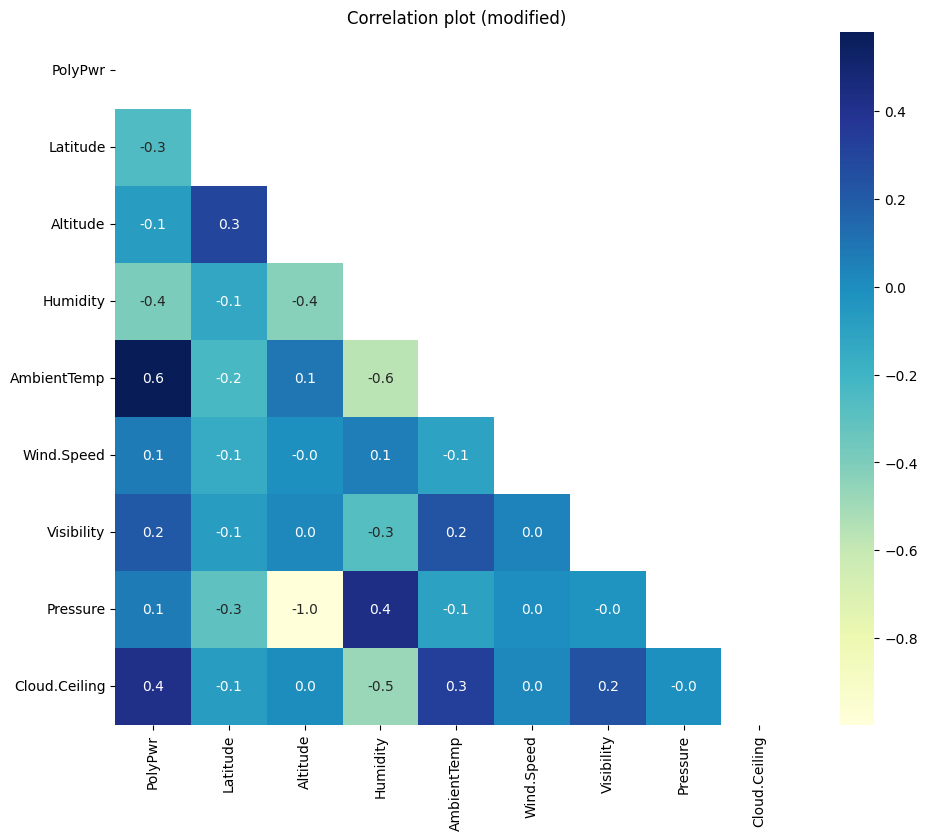

In [45]:
solar.pop("YRMODAHRMI")
solar.pop("Longitude")
solar.pop("Date")
solar.pop("Time")
solar.pop("Hour")
solar.pop("Month")

solar_corr = solar.corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(solar_corr, dtype=bool))
sb.heatmap(solar.corr(), mask=mask, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Correlation plot (modified)")
plt.show()

We need to encode the location and season data, since the data is compiled at different locations over all seasons.
This will allow us to make location and season specific predictions.

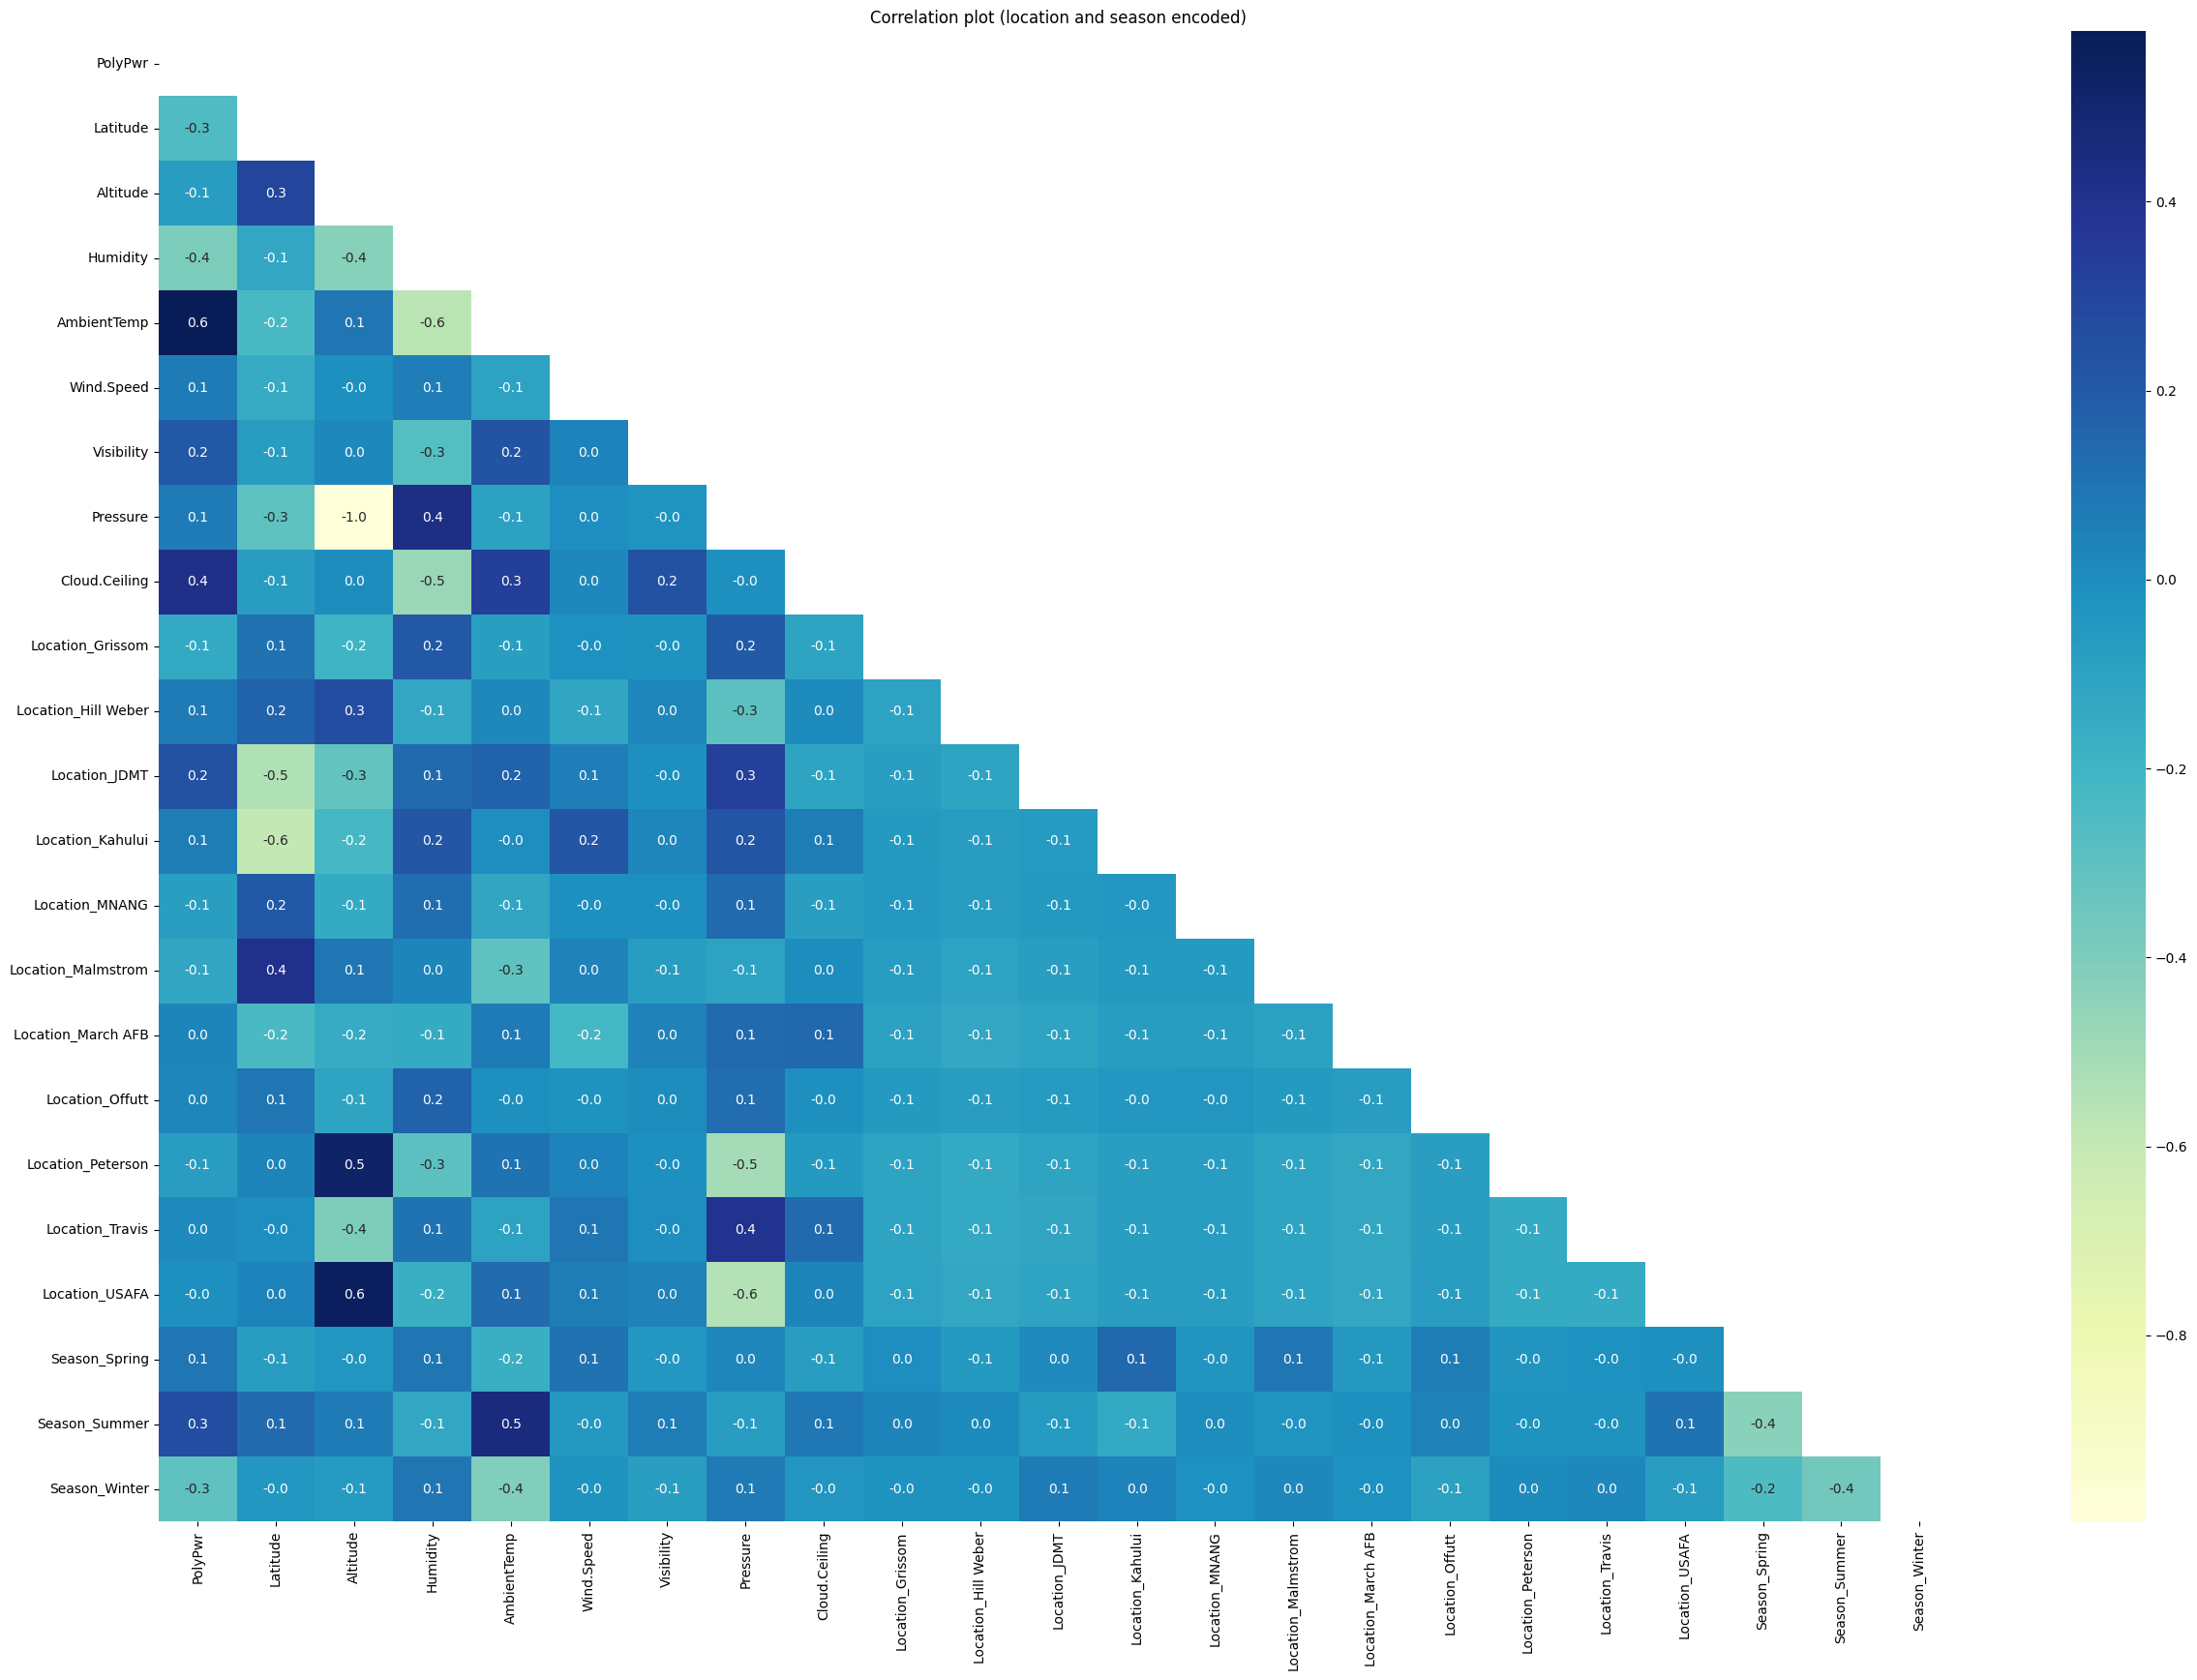

In [46]:
solar_with_location_en = pd.get_dummies(solar, columns=['Location'], drop_first=True)
solar_with_loc_season_en = pd.get_dummies(solar_with_location_en, columns=['Season'], drop_first=True)

mask2 = np.triu(np.ones_like(solar_with_loc_season_en.corr(), dtype=bool))

f, ax = plt.subplots(figsize=(30, 20))
sb.heatmap(solar_with_loc_season_en.corr(), mask=mask2, cmap="YlGnBu", annot=True, fmt='.1f');
plt.title("Correlation plot (location and season encoded)")
plt.show()



# K- Nearest Neighbors (Predefined)


---


Python has a native KNN regression function, where we only need to load our data set, divide into training and test sets and indicate k (nearest neighbors to make the prediction). We will apply this to use as benchmark, and later develop our own version. 

In [47]:
#We need to reload the raw data to be able to use the regression model. When using the data as me modiifed it before we get some errors. 
url = ("https://raw.githubusercontent.com/anacrm00/Solar/main/Pasion_et_al_dataset2.csv")
solar_df = pd.read_csv(url, header=None)
solar_df.columns = ["Location", "Date", "Time", "Latitude", "Longitude","Altitude","YRMODAHRMI", "Month", "Hour", "Season", "Humidity", 
                 "AmbientTemp","PolyPwr", "Wind.Speed", "Visibility","Pressure", "Cloud.Ceiling"]

solar_df = solar_df.reindex(columns=["PolyPwr","Location", "Date", "Time", "Latitude", "Longitude","Altitude","YRMODAHRMI", "Month", "Hour", "Season", "Humidity", 
                 "AmbientTemp", "Wind.Speed", "Visibility","Pressure", "Cloud.Ceiling"])
solar_df.pop("YRMODAHRMI")
solar_df.pop("Longitude")
solar_df.pop("Date")
solar_df.pop("Time")
solar_df.pop("Hour")
solar_df.pop("Month")
solar_df = pd.get_dummies(solar_df)

Splitting the data into training and test sets
> We set 80% of the data for training and 20% for testing

In [48]:
X = solar_df.drop('PolyPwr', axis=1)
y = solar_df['PolyPwr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Initializing the KNN regressor
> Here we define the number of neighbors that will be used to make the prediction



In [49]:
KNN = KNeighborsRegressor(n_neighbors=5)

Fitting the KNN model to the training set

In [50]:
KNN.fit(X_train, y_train)

KNeighborsRegressor()

Now we can make predictions from the testing set

In [51]:
y_pred = KNN.predict(X_test)
df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
print(df_pred)

         y_true     y_pred
20644  17.84274  10.748086
20802  15.79581  13.856348
6836   11.40692  15.039454
5865   23.09664  18.778186
7628   22.65374  18.323106
...         ...        ...
11244  16.25885  18.897550
2909   21.33986  19.236490
17760  23.81649  20.238480
17936  22.31768  19.111912
19919  17.50188  15.050026

[4209 rows x 2 columns]


We observe that the prediction values are very close to the true value in some cases, but in other cases the prediction is further from the true value. Because of this, it might be a good idea to calculate the mean square error to evaluate the performance of the model. 

In [52]:
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: {:.2f}'.format(mse))

Mean squared error: 24.05


Different values of k, produce different errors, so we wish to find the k that minimizes the error:



In [53]:
k_val = []
mse_k = []
for k in range(1, 11):
  k_val.append(k)
  
  KNN = KNeighborsRegressor(n_neighbors=k)
  KNN.fit(X_train, y_train)
  
  y_pred = KNN.predict(X_test)
  df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
  
  mse = mean_squared_error(y_test, y_pred)
  mse_k.append(mse)
  
  print("The mean squared error for k = {} is: {:.2f}".format(k, mse))

optimal_k = k_val[np.argmin(mse_k)]
print("\nThe optimal k is {}".format(optimal_k))

The mean squared error for k = 1 is: 38.45
The mean squared error for k = 2 is: 29.39
The mean squared error for k = 3 is: 26.07
The mean squared error for k = 4 is: 24.79
The mean squared error for k = 5 is: 24.05
The mean squared error for k = 6 is: 23.70
The mean squared error for k = 7 is: 23.47
The mean squared error for k = 8 is: 23.32
The mean squared error for k = 9 is: 23.04
The mean squared error for k = 10 is: 23.09

The optimal k is 9


# K-Nearest neighbors (Self)


---



We can now develop our own KNN regression function. We develop a class to be able to use it in the same way that we use the native python regressor.

To get predictions, we will only need to insert the X variable, this means the independent variables from which we wish to make a prediction. With this class we will obtain the predicted y (PolyPwr) for the X we gave to the model. 



---



Let's recall a simple step by step of how the KNN method works:

**Input**

> Train data set 

> Test data set

**Output**

> Predictions for the test data set

**Steps**

1. Define the number of neighbors, 'k'

2. For each point in the test data set:

>> Calculate the distance from the point to all training data points

>> Sort the distances and select the k nearest neighbors, the k closest to the test point 

>> Calculate the mean of the target variable y (PolyPwr) of the k nearest neighbors

>>Assign this result to the test data point as prediction


In [54]:
class KNNRegressor:
  #Here we initialize the value of k
    def __init__(self, k=6):
        self.k = k
    
    #Defining a 'fit' method to store the X and y variables as attributes to use
    #later. X is the training data and y is the target variable (PolyPwr).
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    #In the predict method we follow the steps of the KNN regression
    #It takes as input the array of test data points X for which we will make predictions.

    def predict(self, X):
        y_pred = []
        for i in range(len(X)):
            euclid_distance = np.sqrt(np.sum((self.X_train - X[i])**2, axis=1))
            k_neighbors = np.argsort(euclid_distance)[:self.k]
            y_neighbors = self.y_train[k_neighbors]
            y_pred.append(np.mean(y_neighbors))
        return y_pred

This class is now ready to be used. We can introduce our data set and obtain predictions. As before, we first need to split the data set into train and test sets. 

In [55]:
url = ("https://raw.githubusercontent.com/anacrm00/Solar/main/Pasion_et_al_dataset2.csv")
solar_df = pd.read_csv(url, header=None)
solar_df.columns = ["Location", "Date", "Time", "Latitude", "Longitude","Altitude","YRMODAHRMI", "Month", "Hour", "Season", "Humidity", 
                 "AmbientTemp","PolyPwr", "Wind.Speed", "Visibility","Pressure", "Cloud.Ceiling"]

solar_df = solar_df.reindex(columns=["PolyPwr","Location", "Date", "Time", "Latitude", "Longitude","Altitude","YRMODAHRMI", "Month", "Hour", "Season", "Humidity", 
                 "AmbientTemp", "Wind.Speed", "Visibility","Pressure", "Cloud.Ceiling"])

solar_df.pop("YRMODAHRMI")
solar_df.pop("Longitude")
solar_df.pop("Date")
solar_df.pop("Time")
solar_df.pop("Hour")
solar_df.pop("Month")

solar_df = pd.get_dummies(solar_df)

X = solar_df.drop('PolyPwr', axis=1).values
y = solar_df['PolyPwr'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KNN = KNNRegressor(k=6)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
print(df_pred)

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: {:.2f}".format(mse))


        y_true     y_pred
0     17.84274  10.747442
1     15.79581  12.091592
2     11.40692  14.409455
3     23.09664  19.675403
4     22.65374  19.345842
...        ...        ...
4204  16.25885  16.794575
4205  21.33986  19.731098
4206  23.81649  18.661237
4207  22.31768  17.765180
4208  17.50188  14.409642

[4209 rows x 2 columns]
Mean squared error: 23.70


We can inmediately note that this implementation takes more time to make a prediction that the native one. This is normal and expected since we are almost 'manually' going through each data point and calculating the distances and averages.

As before, we can calculate the mean squared error to evaluate the performance of the model. We will apply the same ks we did before to compare both implementations. 



In [56]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

k_values = []

mse_values_k = []

for k in range(1, 11):
    k_values.append(k)
    
    knn = KNNRegressor(k=k)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_val)
    
    mse_k = mean_squared_error(y_val, y_pred)
    mse_values_k.append(mse_k)
    print("The mean squared error for k = {} is: {:.2f}".format(k, mse_k))

optimal_k_s = k_values[np.argmin(mse_values_k)]
print("\nThe optimal k is {}".format(optimal_k_s))

The mean squared error for k = 1 is: 38.45
The mean squared error for k = 2 is: 29.39
The mean squared error for k = 3 is: 26.07
The mean squared error for k = 4 is: 24.79
The mean squared error for k = 5 is: 24.05
The mean squared error for k = 6 is: 23.70
The mean squared error for k = 7 is: 23.47
The mean squared error for k = 8 is: 23.32
The mean squared error for k = 9 is: 23.04
The mean squared error for k = 10 is: 23.09

The optimal k is 9


We can see that the optimal k for the function developed is the same as for the preset KNN regressor Python offers. With this, we can confirm that the implemented solution offers results equal or comparable to the predefined function, although it provides the result more slowly, which is an issue with a large dataset

---
There are other methods that work well to make predictions of this type, but
they are much more difficult to develop from scratch and become very complex and computationally costly. Examples of this are Random Forest, Light Gradient Boosting Machine and Deep Neural Network.

As a baseline and introduction to Machine Learning methods, the K-Nearest Neighbors performs adequately and is easy to implement. 

In general, it is good practice to implement these methods ourselves to better understand how they work and adapt them to our problem, but sometimes it becomes to computationally expensive and it is better to use the models and libraries that are already developed and have been optimized, and adapt them to the problem we wish to solve.  